In [24]:
import copy
import numpy as np
import pickle
import random

from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
am = ArgoverseMap()

data_path = '/data/fyy/lanegcn/dataset/dataset/val/data'
avl = ArgoverseForecastingLoader(data_path)
avl.seq_list = sorted(avl.seq_list)

In [33]:
# 读取val中的直行路段, 换道的数据
file_name = '/data/fyy/new_prediction/argoverse_copy/intersection_data/changelane_19-49_val_idx.pkl'
with open(file_name, 'rb') as file:
    changelane_idx = pickle.load(file)

# 读取val预测的结果
file_name = '/data/fyy/new_prediction/argoverse/intersection_data/val_pred.pkl'  
with open(file_name, 'rb') as file:
    preds = pickle.load(file)
print(len(preds))

s_idx = changelane_idx[0]
s_idx = random.sample(s_idx, 300)
l_idx = changelane_idx[1]
r_idx = changelane_idx[2]
print("直行数据的数量", len(s_idx))
print("左转数据的数量", len(l_idx))
print("右转数据的数量", len(r_idx))
print("总数", len(s_idx) + len(l_idx) + len(r_idx))


39472
直行数据的数量 300
左转数据的数量 96
右转数据的数量 188
总数 584


In [34]:
def get_data(idx, avl): 
    city_name = copy.deepcopy(avl[idx].city)
    data_seq = copy.deepcopy(avl[idx].seq_df)   # (len, 6)
    timestamp = np.sort(np.unique(data_seq['TIMESTAMP'].values))
    
    mapping = dict()
    for i, ts in enumerate(timestamp):
        mapping[ts] = i
        
    # 某个场景下的所有轨迹，5s内的轨迹，(len, 2)
    trajs = np.concatenate((
            data_seq.X.to_numpy().reshape(-1, 1),
            data_seq.Y.to_numpy().reshape(-1, 1)), 1)

    steps = [mapping[x] for x in data_seq['TIMESTAMP'].values]
    steps = np.asarray(steps, np.int64)

    objs = data_seq.groupby(['TRACK_ID', 'OBJECT_TYPE']).groups
    keys = list(objs.keys())
    obj_type = [x[1] for x in keys]

    av_idx = obj_type.index('AV')  # av_index = 0，获取AV的索引
    idcs = objs[keys[av_idx]]

    av_traj = trajs[idcs]  # av_traj.shape = (50, 2)
    av_step = steps[idcs]  # av_step.shape = (50,)
    
    # 获取周围车辆的轨迹
    del keys[av_idx]
    ctx_trajs, ctx_steps = [], []  
    for key in keys:
        idcs = objs[key]
        ctx_trajs.append(trajs[idcs])
        ctx_steps.append(steps[idcs])
        
    data = dict()
    data['city'] = city_name
    data['trajs'] = [av_traj] + ctx_trajs
    data['steps'] = [av_step] + ctx_steps
    data['argo_id'] = int(avl.seq_list[idx].name[:-4])

    orig = data['trajs'][0][19].copy().astype(np.float32)
    pre = data['trajs'][0][18] - orig
    theta = np.pi - np.arctan2(pre[1], pre[0])

    rot = np.asarray([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]], np.float32)


    feats, ctrs, gt_preds, has_preds, traj1, trajs2 = [], [], [], [], [], []
    for traj, step in zip(data['trajs'], data['steps']):
        if 19 not in step:
            continue
            
        gt_pred = np.zeros((30, 2), np.float32)
        has_pred = np.zeros(30, bool)
        future_mask = np.logical_and(step >= 20, step < 50)
        post_step = step[future_mask] - 20
        post_traj = traj[future_mask]
        gt_pred[post_step] = post_traj
        has_pred[post_step] = 1


        all_traj = traj.copy().astype(np.float32)
        has_traj = np.zeros(50, bool)
        all_mask = np.logical_and(step >= 0, step < 50)
        all_traj = traj[all_mask]
        all_step = step[all_mask]
        # print(all_traj)
        has_traj[all_step] = 1

        obs_mask = step < 20
        step = step[obs_mask]
        traj = traj[obs_mask]
        idcs = step.argsort()
        step = step[idcs]
        traj = traj[idcs]

        for i in range(len(step)):
            if step[i] == 19 - (len(step) - 1) + i:
                break
        step = step[i:]
        traj = traj[i:]


        feat = np.zeros((20, 3), np.float32)
        feat[step, :2] = np.matmul(rot, (traj - orig.reshape(-1, 2)).T).T
        feat[step, 2] = 1.0


        traj2 = np.zeros((50,3), np.float32)
        traj2[all_step, :2] = np.matmul(rot, (all_traj - orig.reshape(-1,2)).T).T
        traj2[all_step, 2] = 1
        

        x_min, x_max, y_min, y_max = [-100.0, 100.0, -100.0, 100.0]
        if feat[-1, 0] < x_min or feat[-1, 0] > x_max or feat[-1, 1] < y_min or feat[-1, 1] > y_max:
            continue

        ctrs.append(feat[-1, :2].copy())
        traj1.append(feat.copy())

        feat[1:, :2] -= feat[:-1, :2]
        feat[step[0], :2] = 0
        feats.append(feat)
        gt_preds.append(gt_pred)
        has_preds.append(has_pred)
        trajs2.append(traj2)

    feats = np.asarray(feats, np.float32)
    ctrs = np.asarray(ctrs, np.float32)
    gt_preds = np.asarray(gt_preds, np.float32)
    has_preds = np.asarray(has_preds, bool)
    traj1 = np.asarray(traj1, np.float32)
    trajs2 = np.asarray(trajs2, np.float32)

    data['feats'] = feats
    data['traj1'] = traj1
    data['ctrs'] = ctrs
    data['orig'] = orig
    data['theta'] = theta
    data['rot'] = rot
    data['gt_preds'] = gt_preds
    data['has_preds'] = has_preds
    data['trajs2'] = trajs2
    return data

In [35]:
# 检查标签
def check_label(traj, city_name):
    closest_lane_obj, _, dense_centerline = am.get_nearest_centerline(traj[19], city_name) 
    if closest_lane_obj == None or closest_lane_obj.is_intersection == True:
        return -1
    # orig = [list(dense_centerline[0])]    # 轨迹第20帧所在车道, 起始坐标

    #############################前后车道##################################
    s_ctr = []
    if closest_lane_obj.predecessors != None:
        for idx in closest_lane_obj.predecessors:
            if am.get_lane_turn_direction(idx, city_name) == 'NONE':
                pre_lane = am.dfs(idx, city_name, 30, extend_along_predecessor = True)[0]
                for pre_id in pre_lane:
                    s_ctr.append(list(am.get_lane_segment_centerline(pre_id, city_name)[0])[:2])    # 前一车道, 起始坐标
                    # polygon = am.get_lane_segment_polygon(pre_id, city_name)
                    # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')

    if closest_lane_obj.successors != None:
        for idx in closest_lane_obj.successors:
            if am.get_lane_turn_direction(idx, city_name) == 'NONE':
                suc_lane = am.dfs(idx, city_name, 30, extend_along_predecessor = False)[0]
                for suc_id in suc_lane:
                    s_ctr.append(list(am.get_lane_segment_centerline(suc_id, city_name)[0])[:2])    # 后一车道, 起始坐标
                    # polygon = am.get_lane_segment_polygon(suc_id, city_name)
                    # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')
        
    #############################左车道前后##################################
    l_ctr = []
    if closest_lane_obj.l_neighbor_id != None:
        l_pre_lane = am.dfs(closest_lane_obj.l_neighbor_id, city_name, 30, extend_along_predecessor = True)[0]
        l_suc_lane = am.dfs(closest_lane_obj.l_neighbor_id, city_name, 30, extend_along_predecessor = False)[0]
        for l_pre_id in l_pre_lane:
            l_ctr.append(list(am.get_lane_segment_centerline(l_pre_id, city_name)[0])[:2]) 
            # polygon = am.get_lane_segment_polygon(l_pre_id, city_name)
            # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')  
        for l_suc_id in l_suc_lane:
            l_ctr.append(list(am.get_lane_segment_centerline(l_suc_id, city_name)[0])[:2])
            # polygon = am.get_lane_segment_polygon(l_suc_id, city_name)
            # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')
    
    #############################右车道的前后##################################
    r_ctr = []
    if closest_lane_obj.r_neighbor_id != None:
        r_pre_lane = am.dfs(closest_lane_obj.r_neighbor_id, city_name, 30, extend_along_predecessor = True)[0]
        r_suc_lane = am.dfs(closest_lane_obj.r_neighbor_id, city_name, 30, extend_along_predecessor = False)[0]
        for r_pre_id in r_pre_lane:
            r_ctr.append(list(am.get_lane_segment_centerline(r_pre_id, city_name)[0])[:2]) 
            # polygon = am.get_lane_segment_polygon(r_pre_id, city_name)
            # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')
        for r_suc_id in r_suc_lane:
            r_ctr.append(list(am.get_lane_segment_centerline(r_suc_id, city_name)[0])[:2])
            # polygon = am.get_lane_segment_polygon(r_suc_id, city_name)
            # plt.plot(polygon[:, 0], polygon[:, 1], color = 'purple')   
        
    closest_lane_obj_end, _, dense_centerline_end = am.get_nearest_centerline(traj[30], city_name) 
    if closest_lane_obj_end == None or closest_lane_obj_end.is_intersection == True:
        return -1
    cur = list(dense_centerline_end[0])   # 最末帧轨迹所在车道, 起始坐标

    if cur in s_ctr:
        return [1, 0, 0]
    elif cur in l_ctr:
        return [0, 1, 0]
    elif cur in r_ctr:
        return [0, 0, 1]
    else:
        return [0, 0, 0]


In [36]:
data_idx = r_idx + l_idx + s_idx
correct, data_num = 0, 0
change_lane = []
real_labels, pred_labels = [], []

for i in range(len(data_idx)):
    idx = data_idx[i]
    data = get_data(idx, avl)
    city_name = data['city']
    orig = data['orig']
    seq_id = data['argo_id']
    rot = data['rot']
    trajs_obs = data['trajs']
    traj_real = trajs_obs[0]
    traj_pred = np.concatenate((traj_real[:20], preds[seq_id][0]), axis=0)    # fake
    
    real_label = check_label(traj_real, city_name)
    pred_label = check_label(traj_pred, city_name)
    if real_label == [0, 0, 0] or pred_label == [0, 0, 0] or real_label == -1 or pred_label == -1:
        continue
    real_label = real_label.index(1)
    pred_label = pred_label.index(1)
    real_labels.append(real_label)
    pred_labels.append(pred_label)
    
    data_num += 1
    if real_label == pred_label:
        correct += 1


In [37]:
print("正确数量", correct)
print("总数量", data_num)
print("正确率", correct / data_num)

正确数量 225
总数量 230
正确率 0.9782608695652174


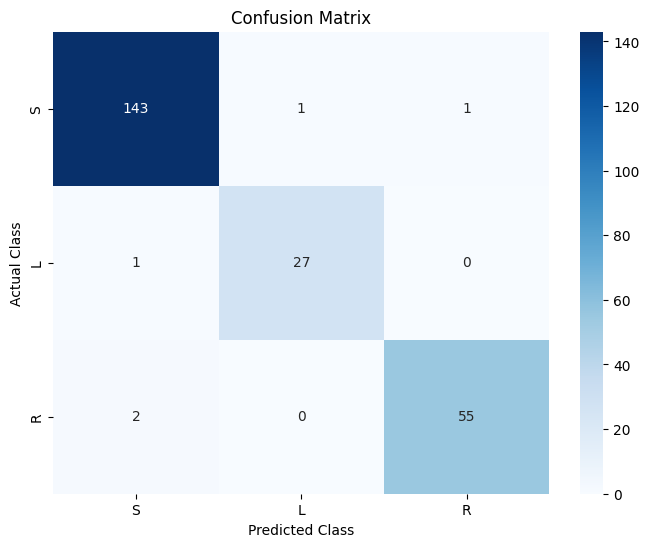

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
 
# 计算混淆矩阵
cm = confusion_matrix(real_labels, pred_labels)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['S', 'L', 'R'], yticklabels=['S', 'L', 'R'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.savefig('av_cm.png')
plt.show()


绘制

In [39]:
import matplotlib.pyplot as plt
from vis_utils import ArgoMapVisualizer
map_vis = ArgoMapVisualizer()

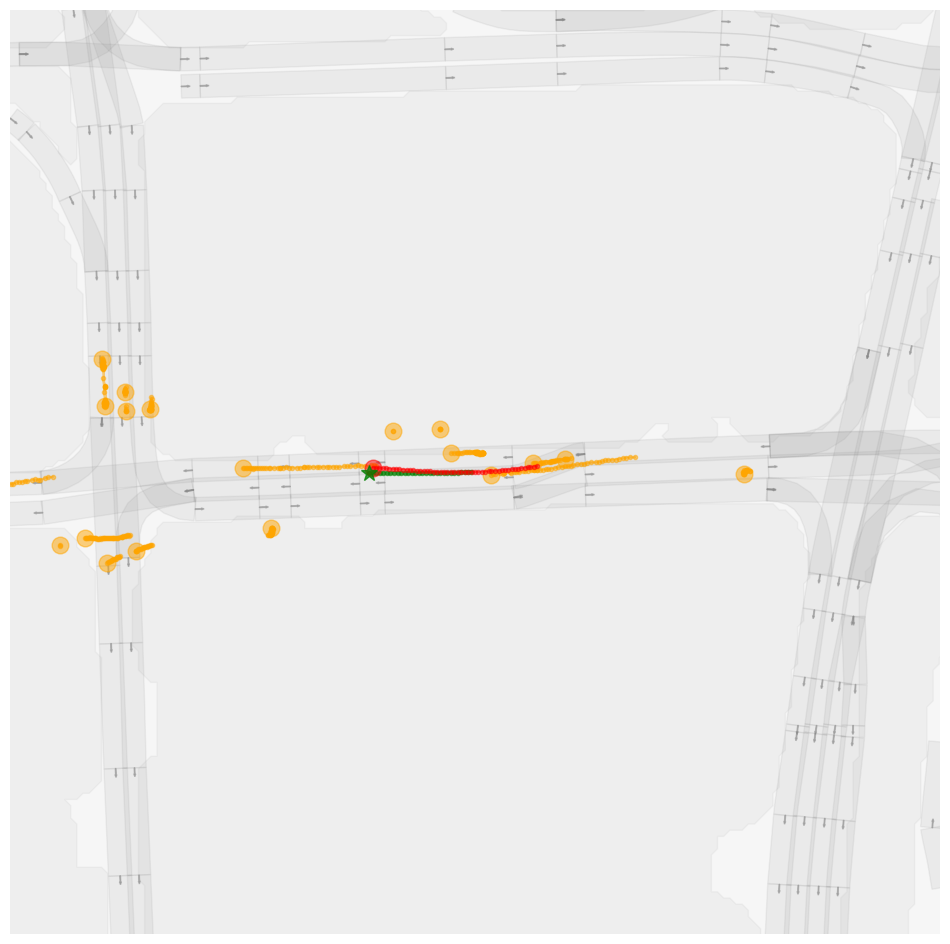

In [40]:

i = 1
idx = r_idx[i]
data = get_data(idx, avl)
city_name = data['city']
orig = data['orig']
seq_id = data['argo_id']
rot = data['rot']
trajs_obs = data['trajs']
traj_real = trajs_obs[0]
traj_pred = np.concatenate((traj_real[:20], preds[seq_id][0]), axis=0)    # fake

_, ax = plt.subplots(figsize=(12, 12))
ax.axis('equal')
plt.axis('off')
map_vis.show_surrounding_elements(ax, city_name, orig)

for i, traj in enumerate(trajs_obs):
    traj = trajs_obs[i]
    zorder = 10
    if i == 0:
        clr = 'r'
        zorder = 20
    else:
        clr = 'orange'
    ax.plot(traj[:, 0], traj[:, 1], marker='.', alpha=0.5, color=clr, zorder=zorder)
    ax.plot(traj[-1, 0], traj[-1, 1], alpha=0.5, color=clr, marker='o', zorder=zorder, markersize=12)

av_traj_pred = traj_pred[20:]
ax.plot(av_traj_pred[:, 0], av_traj_pred[:, 1], alpha=0.5, color='g', linewidth=3, marker='.', zorder=15)
ax.plot(av_traj_pred[-1, 0], av_traj_pred[-1, 1], marker='*', color='g', markersize=12, alpha=0.75, zorder=30)
# plt.savefig('my_plotb3_5.png', format='png', dpi=300)
